In [14]:
import glob
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import tqdm

import time
import os

In [15]:
#load dataset from npy file
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt




In [16]:
args={}
kwargs={}
args['batch_size']=64
args['test_batch_size']=64
args['epochs']=40  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=0.01 #Learning rate is how fast it will decend. 
args['momentum']=0.5 #SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).

args['seed']=1 #random seed
args['log_interval']=100 // args['batch_size']
args['cuda']=False


In [17]:
data = np.load('trainset.npy')
data = torch.from_numpy(data)
data = data.permute(0,3,1,2)
label = np.load('trainlabel.npy')
label = torch.from_numpy(label)
test = np.load('testset.npy')
test = torch.from_numpy(test)
test = test.permute(0,3,1,2)




In [18]:
#make dataset with data and label
class MyDataset(Dataset):

    def __init__(self, data, label,train = True,transform= None):
        
        if train:
            self.data = data
            self.label = label
        else:
            self.data = test
            self.label = None

        self.transform = transform

         
        
    def __getitem__(self, index):
        data = self.data[index]    
        # if self.transform:
        #     self.data = self.transform(self.data)

        if self.label is not None:
            label = self.label[index]
            return data, label
        else:
            return data
    def __len__(self):
        return len(self.data)

    

In [19]:
class testDataset(Dataset):

    def __init__(self, data, transform= None):
        
        self.data = test
        self.label = None
        self.transform = transform

    def __getitem__(self, index):
        data = self.data[index]    
        return data
    def __len__(self):
        return len(self.data)

In [20]:
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

trainset = MyDataset(data, label,train = True,transform= transform_train)
trainset , valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = testDataset(data,transform= transform_test)
trainloader = DataLoader(trainset, batch_size= args['batch_size'], shuffle= True)
valloader = DataLoader(valset, batch_size= args['batch_size'], shuffle= True)
testloader = DataLoader(testset, batch_size= args['batch_size'], shuffle= False)


40000
10000
10000
625
157
157


torch.Size([3, 32, 32])
tensor(45)


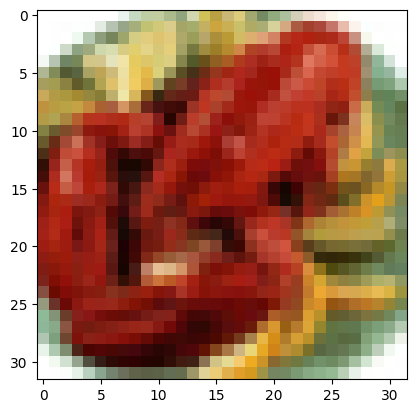

torch.Size([3, 32, 32])
tensor(86)


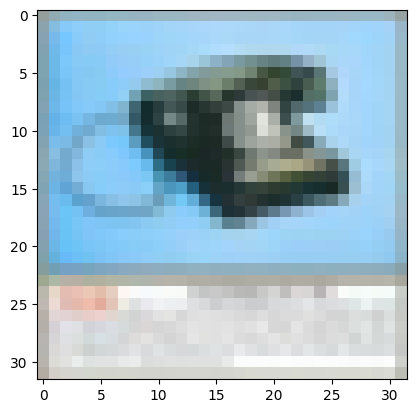

torch.Size([3, 32, 32])
tensor(71)


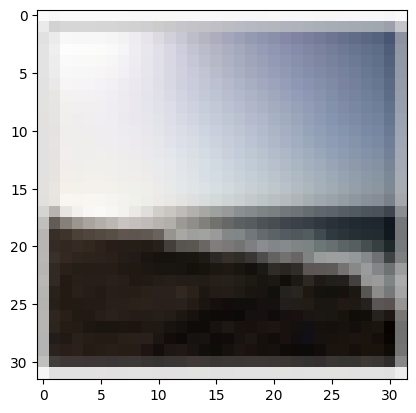

torch.Size([3, 32, 32])
tensor(28)


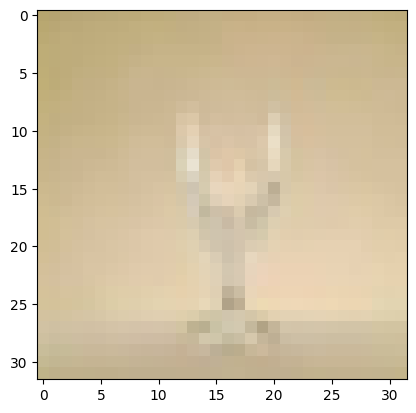

torch.Size([3, 32, 32])
tensor(44)


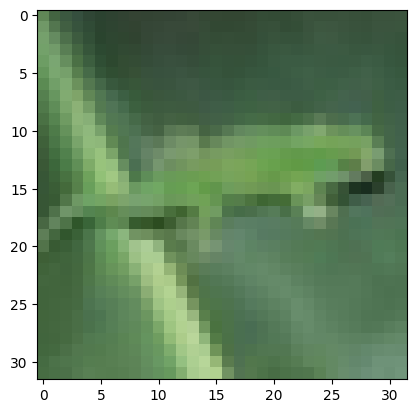

In [21]:
#check the dataset
print(len(trainset))
print(len(valset))
print(len(testset))
print(len(trainloader))
print(len(valloader))
print(len(testloader))
print()


data, label = next(iter(trainloader))
data, label
print()

#check the trainset images with label
for i in range(5):
    data,label = trainset[i]
    print(data.shape)
    print(label)
    plt.imshow(torch.permute(data, (1, 2, 0)), cmap='gray')
    plt.show()





    x = x.permute(0,3,1,2)####

In [22]:
#32*32*3 convolutional neural network (two convolutional layers)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x




In [23]:
for batch, (X,y)in enumerate(trainloader):
    print(batch)
    print(X.shape)
    print(y.shape)
    break

0
torch.Size([64, 3, 32, 32])
torch.Size([64])


In [24]:

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.float())
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 128 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct



In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

model = Net().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

Using cpu device


In [26]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

63092

In [27]:

base_correct = 0
for t in range(args['epochs']):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(trainloader, model, loss_fn, optimizer)
    correct = test_loop(valloader, model, loss_fn)
    if correct > base_correct:
        print('save model')
        torch.save(model.state_dict(), 'model3.pt')
        base_correct = correct
print("Done!")

Epoch 1
-------------------------------
loss: 11.782025  [    0/40000]
loss: 4.554714  [ 8192/40000]
loss: 4.318722  [16384/40000]
loss: 4.247023  [24576/40000]
loss: 4.032528  [32768/40000]
Test Error: 
 Accuracy: 10.9%, Avg loss: 3.959057 

save model
Epoch 2
-------------------------------
loss: 3.645318  [    0/40000]
loss: 3.803795  [ 8192/40000]
loss: 3.882558  [16384/40000]
loss: 3.759602  [24576/40000]
loss: 3.460454  [32768/40000]
Test Error: 
 Accuracy: 15.9%, Avg loss: 3.640239 

save model
Epoch 3
-------------------------------
loss: 3.335840  [    0/40000]
loss: 3.351321  [ 8192/40000]
loss: 3.404648  [16384/40000]
loss: 3.352123  [24576/40000]
loss: 3.204302  [32768/40000]
Test Error: 
 Accuracy: 19.4%, Avg loss: 3.437542 

save model
Epoch 4
-------------------------------
loss: 3.259284  [    0/40000]
loss: 3.224098  [ 8192/40000]
loss: 3.257063  [16384/40000]
loss: 2.991694  [24576/40000]
loss: 3.393232  [32768/40000]
Test Error: 
 Accuracy: 20.3%, Avg loss: 3.407988 

In [28]:
import csv

In [29]:
id_list = []
pred_list = []
_id = 0
model.eval()
with torch.no_grad():
    for x in testloader:
        preds = model(x.float())
        preds = preds.argmax(1)
        for pred in preds:
            id_list.append(_id)
            pred_list.append(pred.item())
            _id += 1

res = pd.DataFrame({
    'id_idx': id_list,
    'label': pred_list
}) 

res.sort_values(by='id_idx', inplace=True)

res.to_csv('./result.csv', index=False) 